# Downloading elements for the task

In [ ]:
!python -m spacy download en_core_web_lg

2023-10-29 09:31:32.479659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 09:31:32.479716: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 09:31:32.479762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 09:31:32.494252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 09:31:34.855594: W tensorflow/compiler/

# Importing Libraries

In [ ]:
import spacy
import json
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import filter_spans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
import string
# typing
from typing import List, Callable, Dict

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer

## Structure of json file
* dict which contain 3 keys: id, passages, relations
  * passages: list of dict where ech dict contain information for named entity recognition: it contains the type of entity and where is located
  * relations: list of dict, each dict contains the type of relation between entities

## Importing train, test and validation data from json file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path to extract the json files, change the past in case you run the repository in local

In [ ]:
train_path = '/content/drive/MyDrive/Cassano_Lorenzo_task/BioRED/Train.BioC.JSON'
test_path = '/content/drive/MyDrive/Cassano_Lorenzo_task/BioRED/Test.BioC.JSON'
val_path = '/content/drive/MyDrive/Cassano_Lorenzo_task/BioRED/Dev.BioC.JSON'

In [ ]:
# Open and read the JSON file

with open(train_path, 'r') as file:
    train_data_j = json.load(file)

with open(test_path, 'r') as file:
    test_data_j = json.load(file)

with open(val_path, 'r') as file:
    val_data_j = json.load(file)

In [ ]:
all_train_documents_information = train_data_j["documents"]
all_test_documents_information = test_data_j["documents"]
all_val_documents_information = val_data_j["documents"]

## Creating data

Useful function to create the structure of data: <br>
Each data is dict where in the key "text" there is the text of document/sentences and entities is a liste where there are the information about the correlation between token/s and entity

In [ ]:
def creating_sample(document: list) -> list:
  """
  The function takes in input the element with key passages
  """
  training_sample = []
  for elem in document:
    temp_dict = {}
    temp_dict['text'] = elem['text']
    temp_dict['entities'] = []
    starting_point = elem['offset']
    for annotation in elem['annotations']:
      start = annotation['locations'][0]['offset'] - starting_point
      end = start + annotation['locations'][0]['length']
      text_label = annotation['text']
      assert elem['text'][start:end] == text_label # checking the correct extraction
      label = annotation['infons']['type'].upper()
      temp_dict['entities'].append((start, end, label))
    training_sample.append(temp_dict)
  return training_sample

### Creating training data

In [ ]:
training_data = []
for document in all_train_documents_information:
  training_sample = creating_sample(document["passages"])
  training_data += training_sample

### Creating test data

In [ ]:
test_data = []
for document in all_test_documents_information:
  test_sample = creating_sample(document["passages"])
  test_data += test_sample

### Creating validation data

In [ ]:
val_data = []
for document in all_val_documents_information:
  val_sample = creating_sample(document["passages"])
  val_data += val_sample

## Inspection of data

In [ ]:
print(f"Len training = {len(training_data)}, len test = {len(test_data)}, lev validation = {len(val_data)}")

Len training = 800, len test = 200, lev validation = 200


Example of structure of the data

In [ ]:
print(f"Training sample = {training_data[0]}\nTest sample = {test_data[0]}\nValidation sample = {val_data[0]}")

Training sample = {'text': 'Hepatocyte nuclear factor-6: associations between genetic variability and type II diabetes and between genetic variability and estimates of insulin secretion.', 'entities': [(0, 27, 'GENEORGENEPRODUCT'), (74, 90, 'DISEASEORPHENOTYPICFEATURE'), (140, 147, 'GENEORGENEPRODUCT')]}
Test sample = {'text': 'A novel SCN5A mutation manifests as a malignant form of long QT syndrome with perinatal onset of tachycardia/bradycardia.', 'entities': [(8, 13, 'GENEORGENEPRODUCT'), (56, 72, 'DISEASEORPHENOTYPICFEATURE'), (97, 108, 'DISEASEORPHENOTYPICFEATURE'), (109, 120, 'DISEASEORPHENOTYPICFEATURE')]}
Validation sample = {'text': 'Congenital hypothyroidism due to a new deletion in the sodium/iodide symporter protein.', 'entities': [(0, 25, 'DISEASEORPHENOTYPICFEATURE'), (55, 78, 'GENEORGENEPRODUCT')]}


# Data analysis

## Observing the number of entity in each class

In [ ]:
def number_entity(data: list) -> dict:
  """
  param: takes in input the list of data
  """
  entity_class = {}
  for doc in data:
    for _,_,entity in doc["entities"]:
      if entity in entity_class:
        entity_class[entity] += 1
      else:
        entity_class[entity] = 1
  return entity_class

In [ ]:
entity_class_train = number_entity(training_data)
entity_class_test = number_entity(test_data)
entity_class_val = number_entity(val_data)

In [ ]:
def plot_entities(entity_class: dict, name=""):
  keys = list(entity_class.keys())
  values = list(entity_class.values())
  plt.bar(keys, values)
  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)
  plt.xlabel('Entity Types')
  plt.ylabel('Frequency')
  plt.title(name)
  # Show the plot
  plt.tight_layout()
  plt.show()


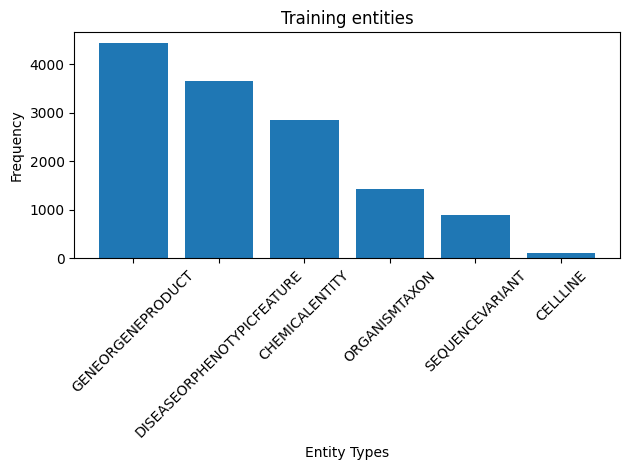

In [ ]:
plot_entities(entity_class_train, name="Training entities")

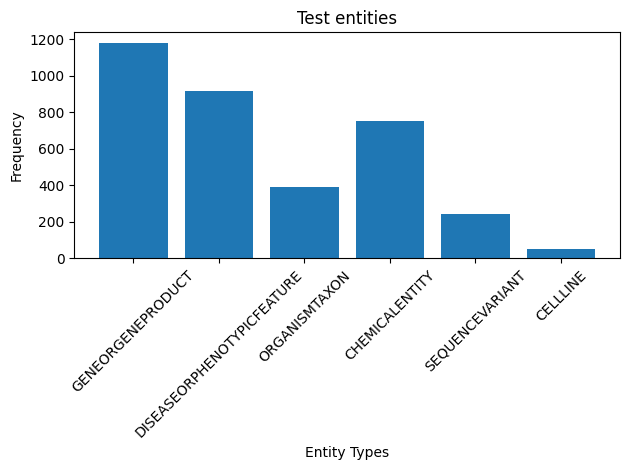

In [ ]:
plot_entities(entity_class_test, name="Test entities")

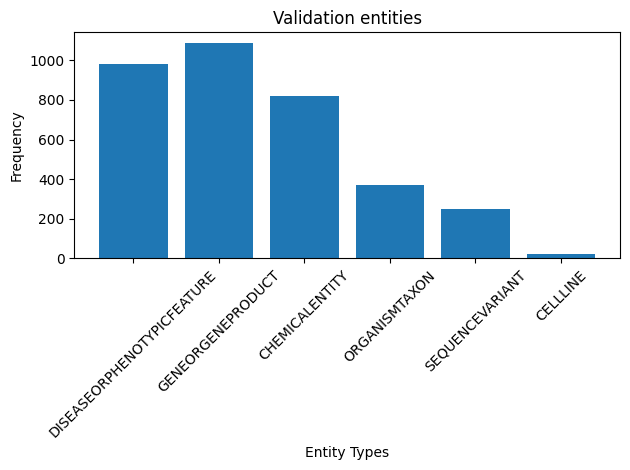

In [ ]:
plot_entities(entity_class_val, name="Validation entities")

## Comments
As you can see, the dataset exhibits class imbalance, particularly noticeable in the 'CELLINE' class. There are very few training examples for this specific class. Additionally, the 'SequenceVariant' and 'OrganismTaxon' classes also show a lack of balance compared to the other classes.

## Observing the number of document in each class

In [ ]:
def number_abstract(data: list) -> dict:
  abstract = {}
  for document in data:
    count = {}
    for _, _, entity in document["entities"]:
      count[entity] = 1
    for elem in count.keys():
      if elem in abstract:
        abstract[elem] += 1
      else:
        abstract[elem] = 1
  return abstract

abstract_class_train = number_abstract(training_data)
abstract_class_test = number_abstract(test_data)
abstract_class_val = number_abstract(val_data)

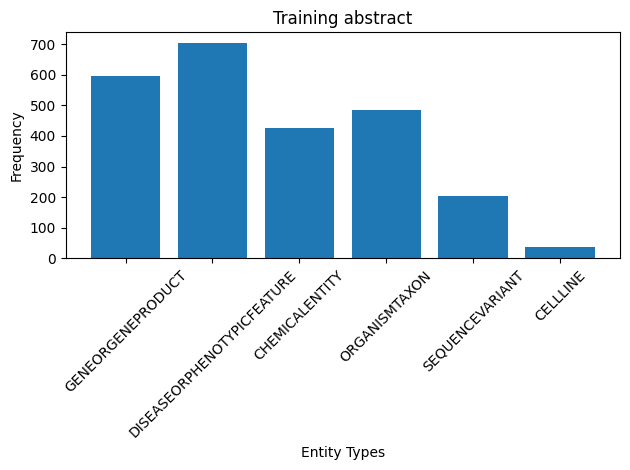

In [ ]:
plot_entities(abstract_class_train, name="Training abstract")

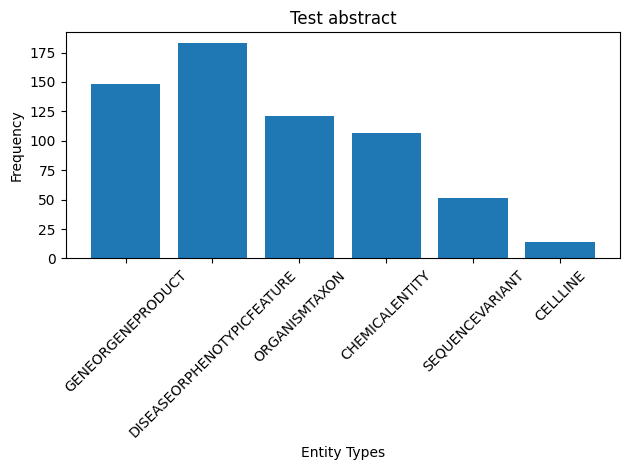

In [ ]:
plot_entities(abstract_class_test, name="Test abstract")

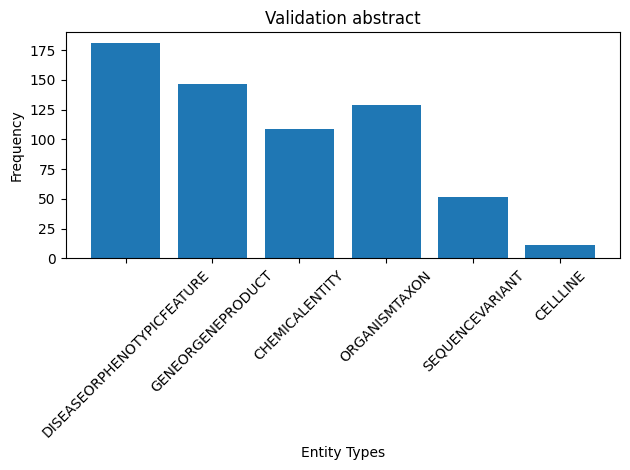

In [ ]:
plot_entities(abstract_class_val, name="Validation abstract")

## Comments
What's intriguing is that the entity that occurs more frequently doesn't necessarily match the entity that occurs most frequently. In the training set, the distribution appears well-balanced, with the exception of the 'Celline' class

## Co-occurences Matrix

In [ ]:
def creating_occurences_matrix(data:list) -> dict:
  co_occurrence_matrix = defaultdict(lambda: defaultdict(int))
  for document in data:
    entities = [entity[2] for entity in document.get('entities', [])]
    for entity1 in entities:
        for entity2 in entities:
          co_occurrence_matrix[entity1][entity2] += 1
  return co_occurrence_matrix

def plot_occurences_matrix(co_occurrence_matrix: dict):
  entity_types = list(co_occurrence_matrix.keys())
  matrix_data = np.array([[co_occurrence_matrix[row][col] for col in entity_types] for row in entity_types])
  # Create a heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(matrix_data, annot=True, fmt='d', xticklabels=entity_types, yticklabels=entity_types)
  plt.title('Entity Type Co-occurrence Heatmap')
  plt.show()

co_occurrence_matrix_train = creating_occurences_matrix(training_data)
co_occurrence_matrix_test = creating_occurences_matrix(test_data)
co_occurrence_matrix_val = creating_occurences_matrix(val_data)

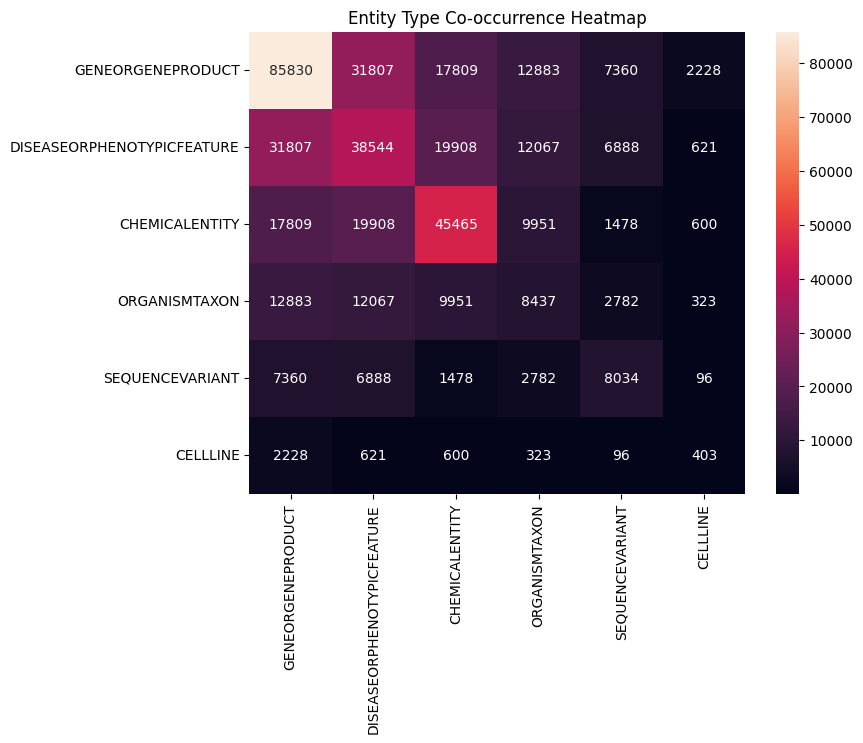

In [ ]:
plot_occurences_matrix(co_occurrence_matrix_train)

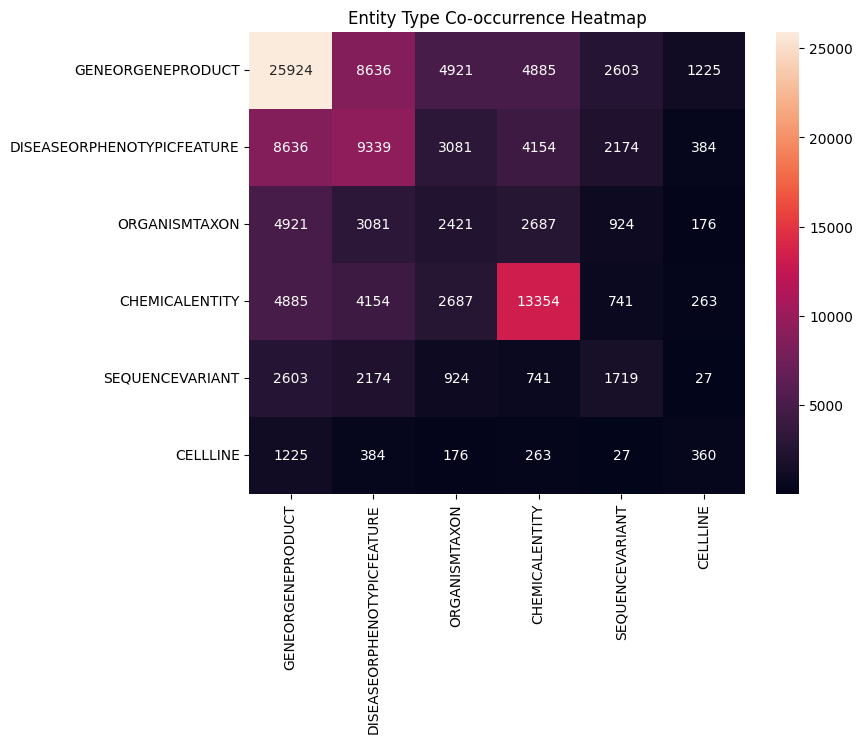

In [ ]:
plot_occurences_matrix(co_occurrence_matrix_test)

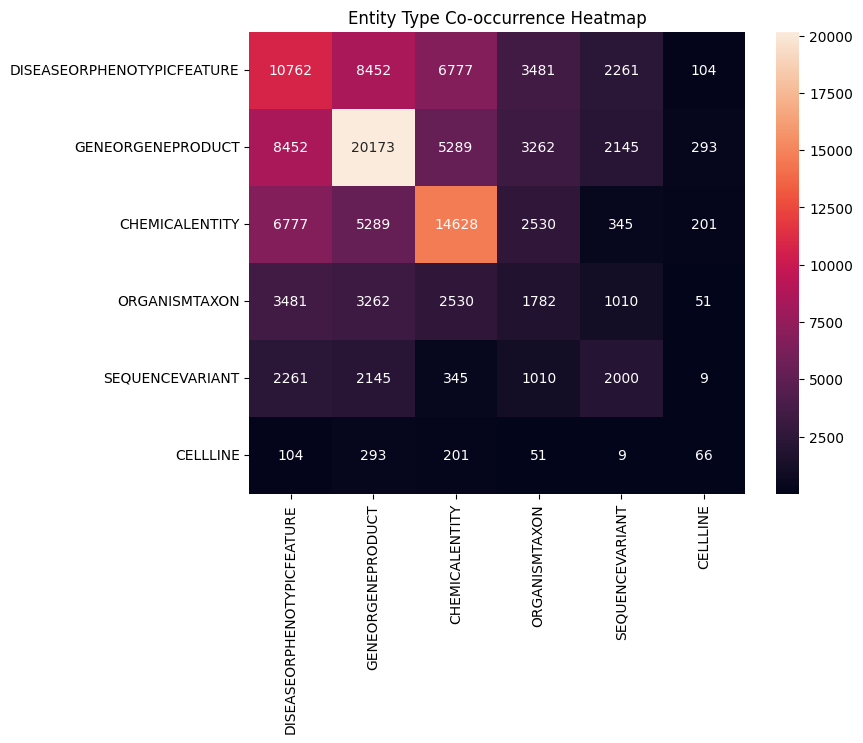

In [ ]:
plot_occurences_matrix(co_occurrence_matrix_val)

## Creation of model

SpaCy’s NER model is pre-trained model, trained on a large annotated dataset. <br>
Spacy Ner System architecture:
* Tok2Vec, this is the architecture to encode the embeddings
  * Creation of embedding
  * Encoding:  computes a a sentence matrix, where each row represents the meaning of each token in the context of the rest of the sentence. This part is done using a bidirectional RNN.
  * Attend: reduces the matrix representation produced by the encode step to a single vector, it takes in input also an auxiliary context vector. Context tells you which information to discard.
  * Once the text or pair of texts has been reduced into a single vector, we can learn the target representation.


* Parser: Last part of the architecture where is aim is to predict the class (in this case the entity)

  <br>


## Preparation of data
In spacy the data for the creation of NER model requires a specific format, each data has to have the text and a list of the entities where each entity is represented by a start position end position (encodes the part of text) and the label associated

In [ ]:
nlp = spacy.blank("en") # load a new spacy model

In [ ]:
def prepare_data(data: list, name: str ="train"):
  print(f"Preparing {len(data)} data")
  doc_bin = DocBin()
  skip = 0
  i = 0
  for example  in tqdm(data):
    text = example['text']
    labels = example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
      span = doc.char_span(start, end, label=label, alignment_mode="contract")
      if span is None:
        skip += 1
      else:
        ents.append(span)
        i += 1
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

  print("Entity skipped = ",skip)
  print("Entity inserted = ",i)
  doc_bin.to_disk(name + ".spacy")

In [ ]:
prepare_data(training_data, name="train")

Preparing 800 data


100%|██████████| 800/800 [00:03<00:00, 241.20it/s]


Entity skipped =  365
Entity inserted =  12986


In [ ]:
prepare_data(val_data, name="val")

Preparing 200 data


100%|██████████| 200/200 [00:00<00:00, 214.67it/s]


Entity skipped =  68
Entity inserted =  3465


In [ ]:
prepare_data(test_data, name="test")

Preparing 200 data


100%|██████████| 200/200 [00:00<00:00, 340.04it/s]

Entity skipped =  37
Entity inserted =  3498


## Model
For the creation of the model we need to use a base config file, which is located in the folder path : /content/drive/MyDrive/Cassano_Lorenzo_task/base_config.cfg

In [ ]:
#https://spacy.io/usage/training#quickstart

In [ ]:
!python -m spacy init fill-config /content/drive/MyDrive/Cassano_Lorenzo_task/base_config.cfg config.cfg

2023-10-28 21:31:13.662660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 21:31:13.662736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 21:31:13.662780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 21:31:15.092732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Now, it has been created a file: config.cfg; we need to set the Epoch <br>
The experiments have been trien on 10 epochs

In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./val.spacy --gpu-id 0

2023-10-28 21:32:19.086873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 21:32:19.087702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 21:32:19.087761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 21:32:20.705381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline

In [ ]:
nlp_best = spacy.load("model-best")

In [ ]:
to_text = test_data[1]["text"] # taken a test sample

In [ ]:
doc = nlp_best(to_text)


spacy.displacy.render(doc, style="ent", jupyter=True)

## Evaluation:
### Metric used:
* $\text{Precision = }\frac{TP}{TP + FP}$
<br> <br>
* $\text{Recall = }\frac{TP}{TP + FN}$
<br> <br>
* $\text{F1 = }\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$



In [ ]:
!python -m spacy benchmark accuracy ./model-best --output /content/drive/MyDrive/Cassano_Lorenzo_task/output.json --gold-preproc ./test.spacy --gpu-id 0

2023-10-28 21:50:56.490907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 21:50:56.490971: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 21:50:56.491011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 21:50:57.953470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK     100.00
NER P   77.59 
NER R   72.47 
NER F   74.94 
SPEED   9876  


=============================== NER (per type) ===================

With this results is possible also to compute the macro precision and macro recall: <br>
<br>
$$
\text{Macro Precision (MP)} = \frac{1}{N} \sum_{i=1}^{N} \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Macro Recall (MR)} = \frac{1}{N} \sum_{i=1}^{N} \frac{TP_i}{TP_i + FN_i}
$$

In [ ]:
output_path = "/content/drive/MyDrive/Cassano_Lorenzo_task/output.json"
with open(output_path, 'r') as file:
    output = json.load(file)

In [ ]:
results = output["ents_per_type"]

In [ ]:
def macro_precision(results:dict):
  precision_sum = 0
  for entity in results.keys():
    precision_sum += results[entity]["p"]
  return precision_sum / len(results)

def macro_recall(results:dict):
  precision_sum = 0
  for entity in results.keys():
    precision_sum += results[entity]["r"]
  return precision_sum / len(results)

In [ ]:
print(f"Macro precision = {macro_precision(results):.3f}\nMacro recall = {macro_recall(results):.3f}")

Macro precision = 0.717
Macro recall = 0.677


## Improving model

So far, we do not perform a great preprocessing step:<br>
Now we try to improve the performance including some preprocessing steps.<br>
Preprocsseing step tried:
* lowercase
* replacing spacial characters (for i.e. "@;" etc.)
* removing stopwords (the,an,a, etc.)
* removing useless whithespace
* Lemming

### Defining some useful pre-processing functions

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')

try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

## Lemmatizzation
In this step it can be choosen either stemming or lemming.
* *''Lemmatization usually refers to use a vocabulary and morphological analysis of words to return the base or dictionary form of a word, known as **lemma**''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*saw*, *seen*, *sees* $\rightarrow$ *see*


## Stemming
*''Stemming usually refers to a crude heuristic process that **chops off** the ends of words to reduce words to a common form.''*

<div align='right'>
(Introduction to Information Retrieval ~ C. D. Manning)
</div>

**Example**

*programmer*, *programs*, *programming* $\rightarrow$ *program*

## Explanation
Lemmatization is often preferred over stemming because it provides linguistically meaningful word forms, which can lead to better comprehension and accuracy in natural language processing tasks. Stemming, on the other hand, may result in more aggressive and sometimes nonsensical word truncations

### Useful dowload for lemmatization

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def get_wordnet_key(pos_tag: str) -> str:
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str) -> str:
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

In [ ]:
PREPROCESSING_PIPELINE = [
                          #lower,
                          replace_special_characters,
                          remove_stopwords,
                          strip_text,
                          lem_text
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [ ]:
def creating_sample_preprocess(document: list) -> list:
  """
  The function takes in input the element with key passages
  """
  training_sample = []
  for elem in document:
    temp_dict = {}
    temp_dict['text'] = text_prepare(elem['text'])
    temp_dict['entities'] = []
    starting_point = 0
    for annotation in elem['annotations']:
      text_label = text_prepare(annotation['text'])
      start = temp_dict['text'].find(text_label, starting_point)
      if start == -1:
        assert("Error!!!")
        break
      end = start + len(text_label)
      assert temp_dict['text'][start:end] == text_label # checking the correct extraction
      label = annotation['infons']['type'].upper()
      temp_dict['entities'].append((start, end, label))
      startin_point = end + 1 # updating starting point
    training_sample.append(temp_dict)
  return training_sample

### Creating clean training test and validation data

In [ ]:
training_data_clean = []
for document in tqdm(all_train_documents_information):
  training_sample = creating_sample_preprocess(document["passages"])
  training_data_clean += training_sample

100%|██████████| 400/400 [00:09<00:00, 43.35it/s]


In [ ]:
test_data_clean = []
for document in tqdm(all_test_documents_information):
  test_sample = creating_sample_preprocess(document["passages"])
  test_data_clean += test_sample

100%|██████████| 100/100 [00:01<00:00, 61.77it/s]


In [ ]:
val_data_clean = []
for document in tqdm(all_val_documents_information):
  val_sample = creating_sample_preprocess(document["passages"])
  val_data_clean += val_sample

100%|██████████| 100/100 [00:01<00:00, 60.89it/s]


In [ ]:
training_data_clean[0]

{'text': 'Hepatocyte nuclear factor-6: association genetic variability type II diabetes genetic variability estimate insulin secretion',
 'entities': [(0, 27, 'GENEORGENEPRODUCT'),
  (61, 77, 'DISEASEORPHENOTYPICFEATURE'),
  (107, 114, 'GENEORGENEPRODUCT')]}

### Preparing data for the model


In [ ]:
prepare_data(training_data_clean, name="train_clean")

Preparing 800 data


100%|██████████| 800/800 [00:00<00:00, 1675.89it/s]


Entity skipped =  403
Entity inserted =  12365


In [ ]:
prepare_data(test_data_clean, name="test_clean")

Preparing 200 data


100%|██████████| 200/200 [00:00<00:00, 1617.13it/s]

Entity skipped =  72
Entity inserted =  3259


In [ ]:
prepare_data(val_data_clean, name="val_clean")

Preparing 200 data


100%|██████████| 200/200 [00:00<00:00, 939.75it/s]

Entity skipped =  76
Entity inserted =  3204


In [ ]:
!python -m spacy init fill-config /content/drive/MyDrive/Cassano_Lorenzo_task/base_config.cfg config.cfg

2023-10-28 21:54:48.729803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 21:54:48.729855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 21:54:48.729887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 21:54:49.878515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


it is needed to set the max number of epochs, the max number of epochs tried it has been 10

In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train_clean.spacy --paths.dev ./val_clean.spacy --gpu-id 0

2023-10-28 21:55:47.978771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 21:55:47.978830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 21:55:47.978861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 21:55:49.112217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline

In [ ]:
nlp_ner_clean = spacy.load("model-best")

In [ ]:
to_text = test_data[1]["text"] # taken a test sample
doc = nlp_ner_clean(to_text)


spacy.displacy.render(doc, style="ent", jupyter=True)

In [ ]:
!python -m spacy benchmark accuracy ./model-best --output ./output_test.json --gold-preproc ./test_clean.spacy --gpu-id 0

2023-10-28 22:10:01.889000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 22:10:01.889055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 22:10:01.889094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 22:10:04.011894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK     100.00
NER P   57.86 
NER R   47.99 
NER F   52.47 
SPEED   7683  


=============================== NER (per type) ===================

In [ ]:
output_path = "/content/output_test.json"
with open(output_path, 'r') as file:
    output = json.load(file)

In [ ]:
results = output["ents_per_type"]

In [ ]:
print(f"Macro precision = {macro_precision(results):.3f}\nMacro recall = {macro_recall(results):.3f}")

Macro precision = 0.502
Macro recall = 0.391


## Explanation of the worse performance
Preprocessing can lead to overfitting, especially if it is applied too aggressively. The model may become too specific to the training data and less adaptable to unseen text.
### Other preprocessing step that can be test to try improve a NER Model
* hyperparameters tuning
* Transformer architecture
* <b>Important:</b> Try to handle the unbalanced dataset; possible solutions can be:
  * try to assign different weights to each class during the training, the weights can be assigned in base of the proportion of the number of classes
  * try data augmentation

# Starting baseline for Relation extraction

In this task, the goal is to extract the relationship between entities in text. The dataset is labeled, meaning that it contains the relationships.

## Preparing data

In this case the model needs to have also the information about the relations

In [ ]:
def find_start_end_token(sentence: str, start_char: int, end_char: int) -> tuple:
    starting_word_token = sentence[start_char:end_char].split()[0]
    ending_word_token = sentence[start_char:end_char].split()[len(sentence[start_char:end_char].split()) -1]
    words = sentence.split()
    start_token = None
    end_token = None
    i = 0
    for word in words:
        if starting_word_token in word:
            start_token = i
        if ending_word_token in word and start_token != None: # first we need to find the start
            end_token = i
            break # if whe find the end, we have just found the start
        i +=1

    return start_token, end_token

def creating_relationship_sample(document: list) -> list:
  """
  The function takes in input the element with key passages
  """
  training_sample_rel = []
  for elem,relations in zip(document['passages'],document['relations']):
    temp_dict = {}
    temp_dict['text'] = elem['text']
    temp_dict['entities'] = {}
    word_dict = {}
    starting_point = elem['offset']
    for annotation in elem['annotations']:
      start = annotation['locations'][0]['offset'] - starting_point
      end = start + annotation['locations'][0]['length']
      text_label = annotation['text']

      assert elem['text'][start:end] == text_label # checking the correct extraction

      start_token, end_token = find_start_end_token(elem['text'], start, end)
      assert start_token != None
      assert end_token != None
      assert start_token <= end_token # checking correct extraction

      identifier = annotation['infons']['identifier']
      label = annotation['infons']['type'].upper()
      temp_dict['entities'][identifier] = {'start': start, 'end': end, 'label': label, 'start_token':start_token, 'end_token':end_token}
    temp_dict['relations'] = []
    entity1 = relations['infons']['entity1']
    entity2 = relations['infons']['entity2']
    type_rel = relations['infons']['type'].upper()
    temp_dict['relations'].append({'entity1':entity1, 'entity2':entity2, 'label': type_rel})

    training_sample_rel.append(temp_dict)
  return training_sample_rel

In [ ]:
training_data_rel = []
for document in tqdm(all_train_documents_information):
  training_sample_rel = creating_relationship_sample(document)
  training_data_rel += training_sample_rel

100%|██████████| 400/400 [00:01<00:00, 395.72it/s]


In [ ]:
validation_data_rel = []
for document in all_val_documents_information:
  validation_sample_rel = creating_relationship_sample(document)
  validation_data_rel += validation_sample_rel

In [ ]:
test_data_rel = []
for document in all_test_documents_information:
  test_sample_rel = creating_relationship_sample(document)
  test_data_rel += test_sample_rel

## Explanation of Relation Extraction the baseline
Theoretical explanation of the relation extraction model:
1. The model creates the embeddings using Tok2Vec
2. The goal is created a vector to encode the relationship
3. To create a vector first the model creates a matrix, I use this exampla for the explanation:<br>
Lorenzo was born in Rome <br>
In this case we have the entity PERSON which is Lorenzo and the entity PLACE which is Rome, we know that between Lorenzo Cassano and Rome there is a relationship: BORN. The model creates the matrix in this way:<br>

embedding: Lorenzo<br>
embedding: Rome<br>
embedding: Rome<br>
embedding: Lorenzo<br>

Now we have a matrix of 4 rows and n columns, where n is the dimension used for the embeddings. The matrix has 4 rows because in this case we are considere that the relationship is symmetric. <br>
After that, it is applied a Polling layer (usually the Avereage) in order to obtain a matrix of 2 rows: <br>
Avg: (Lorenzo, Rome) <br>
Avg: (Rome, Lorenzo) <br>
<br>
Finally, the embeddings are concatenated in order to obtain a vector that encodes the relationship.

For prediction, a classification layer is used to associate each instance of data with a relation. This means that for the final output, we have a relation score for each instance of data. Scores that surpass a threshold (usually 0.5) are considered as 'True'.

To build this model, you can use the code file code.py, which is located in the following repository: https://github.com/explosion/projects/tree/v3/tutorials/rel_component <br>